# Задача
Реализовать базовый Embedding MixUp метод (или любой более продвинутый аналог) для аугментации данных для файнтюнинга bert-base-cased (https://huggingface.co/bert-base-cased) на датасете (https://huggingface.co/datasets/rotten_tomatoes) для задачи классификации данных.

Для начала загрузим датасет и посмотрим на него

In [1]:
from datasets import load_dataset

tomato_dataset = load_dataset("cornell-movie-review-data/rotten_tomatoes")
tomato_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

Датасет представляет собой 8530 тренировочных эксземпляров, и по 1066 валидационных и тестовых

Преобразуем тренировочную и валидационную части в пандас датафрейм для первичного анализа

In [2]:
import pandas as pd

train_data = tomato_dataset['train']
validation_data = tomato_dataset['validation']

train_df = pd.DataFrame(train_data)
validation_df = pd.DataFrame(validation_data)

train_df.sample(3)

,text,label
1649,hoffman's performance is authentic to the core...,1
569,"these are lives worth watching , paths worth f...",1
3467,not everything in this ambitious comic escapad...,1


In [3]:
validation_df.info()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066 entries, 0 to 1065
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1066 non-null   object
 1   label   1066 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 16.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8530 entries, 0 to 8529
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    8530 non-null   object
 1   label   8530 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 133.4+ KB


Пропуски в данных отсутствуют. Посмотрим баланс классов

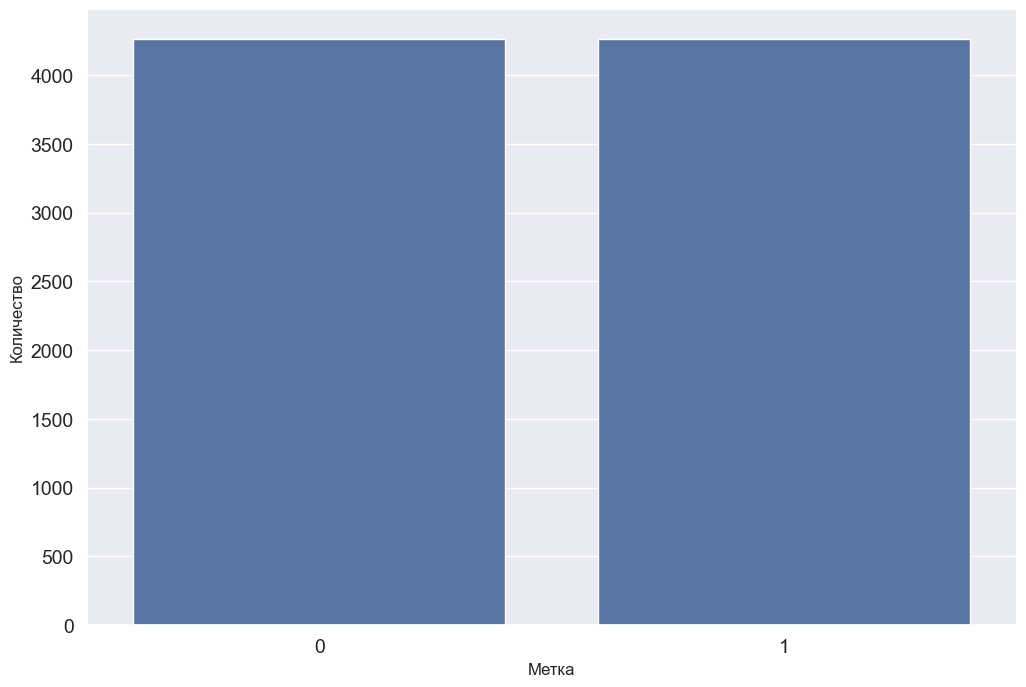

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme() # выставим стандартную тему сиборна
plt.figure(figsize=(12, 8))
ax = sns.countplot(x="label", data=train_df)
ax.set_xlabel("Метка")
ax.set_ylabel("Количество")
ax.set_xticks([0, 1])
ax.tick_params(axis='both', which='major', labelsize=14)
plt.show()

По гистограмме видно, что имеется всего две метки класса и они сбалансированны.

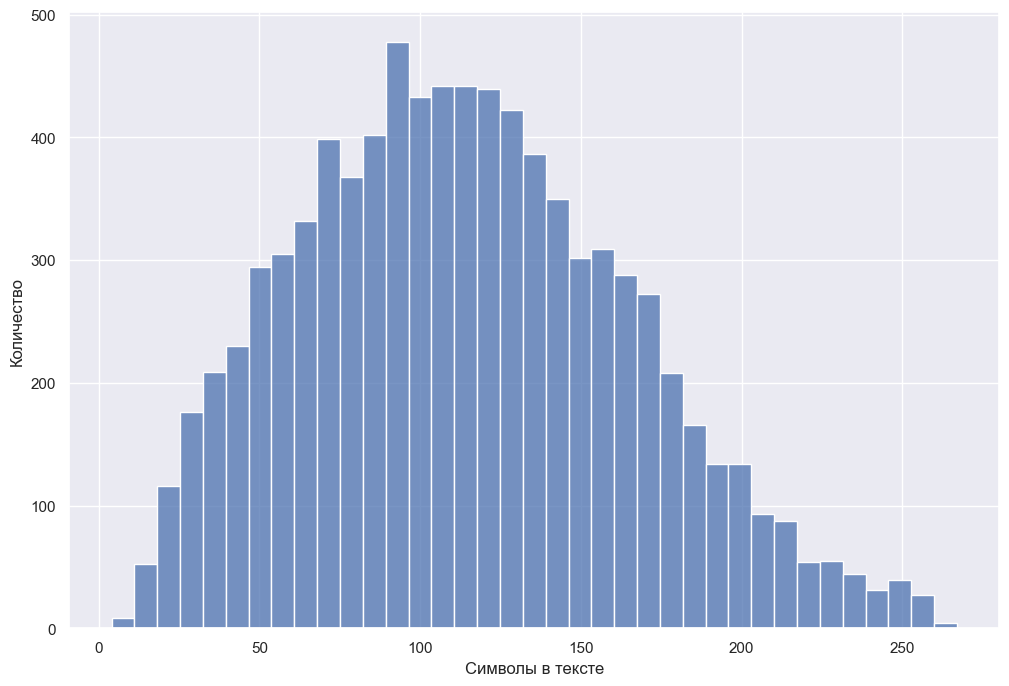

In [25]:
plt.figure(figsize=(12, 8))
char_len = train_df[['text', 'label']]
char_len['text_length'] = char_len['text'].apply(len)
ax = sns.histplot(x="text_length", data=char_len)
ax.set_xlabel("Символы в тексте")
ax.set_ylabel("Количество")
plt.show()


По распределению видно, что даже если мы будем токенезировать каждый символ, то max_length=256 нам с запасом

Так как основная цель работы применить MixUp метод и посмотреть на разницу результата в задачи классификации текста, то дополнительный анализ текста и дополнительная его предобработка (пунктуация, стоп слова и пр.) по больщому счёту не требуются

Начнём с базового случая - предобученный BERT

In [5]:
from transformers import BertTokenizer, DataCollatorWithPadding

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# функция для токенезации данных
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

# токенизируем весь датасет
tokenized_datasets = tomato_dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

# создаём объект датаколлатора который преобразует в батчи датасет
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [6]:
import torch
from transformers import BertForSequenceClassification

# определяем рабочий девайс и грузим болванку берта с линейным слоев на 2 класса
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
Bert_base = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
Bert_base.to(device)
print(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


In [7]:
from transformers import Trainer, TrainingArguments, TrainerCallback
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# функция для передач в тренера. Считаем метрики
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1) # вытаксивааем наиболее вероятных класс
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# настройка Trainer
training_args = TrainingArguments(
    output_dir="./model_base",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=8e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    save_total_limit=1,  # количество сохраняемых моделей
    load_best_model_at_end=True,  
    metric_for_best_model="accuracy", 
)

# создаём кастомный класс для сохранения метрик
class SaveMetricsCallback(TrainerCallback):
    def __init__(self, train_metrics, eval_metrics):
        self.train_metrics = train_metrics
        self.eval_metrics = eval_metrics

    def on_log(self, args, state, control, **kwargs):
        if state.is_world_process_zero:
            self.train_metrics.append(state.log_history[-1])
            if 'eval_loss' in state.log_history[-1]:
                self.eval_metrics.append(state.log_history[-1])

# создаём объект тренера
Bert_base_trainer = Trainer(
    model=Bert_base,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

Так как класса всего 2 и они сбалансированны, то самое простое и разумное - руководствоваться Accuracy

In [8]:
# обучаем базовую моделдь, 
Bert_base_train_metrics, Bert_base_eval_metrics = [], []
Bert_base_trainer.add_callback(SaveMetricsCallback(Bert_base_train_metrics, Bert_base_eval_metrics))
Bert_base_trainer.train()
torch.cuda.empty_cache()

  0%|          | 0/2670 [00:00<?, ?it/s]

C:\Users\Кирилл\AppData\Roaming\Python\Python311\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.36542603373527527, 'eval_accuracy': 0.8358348968105066, 'eval_f1': 0.8492678725236864, 'eval_precision': 0.785031847133758, 'eval_recall': 0.924953095684803, 'eval_runtime': 10.1137, 'eval_samples_per_second': 105.402, 'eval_steps_per_second': 3.362, 'epoch': 1.0}
{'loss': 0.3079, 'grad_norm': 5.450629234313965, 'learning_rate': 6.50187265917603e-05, 'epoch': 1.87}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.48584529757499695, 'eval_accuracy': 0.8480300187617261, 'eval_f1': 0.8591304347826085, 'eval_precision': 0.8006482982171799, 'eval_recall': 0.926829268292683, 'eval_runtime': 10.3374, 'eval_samples_per_second': 103.121, 'eval_steps_per_second': 3.289, 'epoch': 2.0}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.5306076407432556, 'eval_accuracy': 0.8536585365853658, 'eval_f1': 0.8519924098671726, 'eval_precision': 0.8618042226487524, 'eval_recall': 0.8424015009380863, 'eval_runtime': 10.299, 'eval_samples_per_second': 103.505, 'eval_steps_per_second': 3.301, 'epoch': 3.0}
{'loss': 0.0904, 'grad_norm': 6.727640151977539, 'learning_rate': 5.00374531835206e-05, 'epoch': 3.75}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.7473093271255493, 'eval_accuracy': 0.8611632270168855, 'eval_f1': 0.8582375478927202, 'eval_precision': 0.8767123287671232, 'eval_recall': 0.8405253283302064, 'eval_runtime': 10.8692, 'eval_samples_per_second': 98.075, 'eval_steps_per_second': 3.128, 'epoch': 4.0}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.8749993443489075, 'eval_accuracy': 0.848968105065666, 'eval_f1': 0.8591426071741033, 'eval_precision': 0.8049180327868852, 'eval_recall': 0.9212007504690432, 'eval_runtime': 11.4048, 'eval_samples_per_second': 93.469, 'eval_steps_per_second': 2.981, 'epoch': 5.0}
{'loss': 0.0257, 'grad_norm': 0.006958518642932177, 'learning_rate': 3.50561797752809e-05, 'epoch': 5.62}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.8752260804176331, 'eval_accuracy': 0.8705440900562852, 'eval_f1': 0.8722222222222222, 'eval_precision': 0.8610603290676416, 'eval_recall': 0.8836772983114447, 'eval_runtime': 9.6068, 'eval_samples_per_second': 110.963, 'eval_steps_per_second': 3.539, 'epoch': 6.0}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.9348135590553284, 'eval_accuracy': 0.8621013133208255, 'eval_f1': 0.8676867686768678, 'eval_precision': 0.8339100346020761, 'eval_recall': 0.9043151969981238, 'eval_runtime': 10.2518, 'eval_samples_per_second': 103.982, 'eval_steps_per_second': 3.316, 'epoch': 7.0}
{'loss': 0.0044, 'grad_norm': 0.0054045310243964195, 'learning_rate': 2.0074906367041202e-05, 'epoch': 7.49}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.9671202301979065, 'eval_accuracy': 0.8780487804878049, 'eval_f1': 0.879182156133829, 'eval_precision': 0.8710865561694291, 'eval_recall': 0.8874296435272045, 'eval_runtime': 10.2453, 'eval_samples_per_second': 104.048, 'eval_steps_per_second': 3.319, 'epoch': 8.0}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.9651229381561279, 'eval_accuracy': 0.8667917448405253, 'eval_f1': 0.8685185185185185, 'eval_precision': 0.8574040219378428, 'eval_recall': 0.8799249530956847, 'eval_runtime': 10.2474, 'eval_samples_per_second': 104.027, 'eval_steps_per_second': 3.318, 'epoch': 9.0}
{'loss': 0.0022, 'grad_norm': 0.002348229754716158, 'learning_rate': 5.093632958801499e-06, 'epoch': 9.36}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.9647207856178284, 'eval_accuracy': 0.8667917448405253, 'eval_f1': 0.8697247706422018, 'eval_precision': 0.8509874326750448, 'eval_recall': 0.8893058161350844, 'eval_runtime': 10.2966, 'eval_samples_per_second': 103.529, 'eval_steps_per_second': 3.302, 'epoch': 10.0}
{'train_runtime': 2650.2111, 'train_samples_per_second': 32.186, 'train_steps_per_second': 1.007, 'train_loss': 0.08090932849194674, 'epoch': 10.0}


In [9]:
# функция для вытаскивания матрик и их отрисовки. Вообще довольно костыльная
def get_metrics(metrics):
    eval_steps = []
    eval_epochs = []
    train_steps = []
    eval_loss = []
    eval_acc = []
    train_loss = []
    for metric in metrics:
        if 'loss' in metric:
            train_steps.append(metric['step'])
            train_loss.append(metric['loss'])
        elif 'eval_loss' in metric:
            eval_steps.append(metric['step'])
            eval_epochs.append(int(metric['epoch']))
            eval_loss.append(metric['eval_loss'])
            eval_acc.append(metric['eval_accuracy'])
        elif 'train_loss' in metric:
            train_steps.append(metric['step'])
            train_loss.append(metric['train_loss'])
            
    return eval_steps, eval_epochs, train_steps, eval_loss, train_loss, eval_acc

def plot_metrics(eval_steps, eval_epochs, train_steps, eval_loss, train_loss, eval_acc):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    # отрисовкка loss
    ax1.plot(train_steps, train_loss, label='Train Loss', color='blue')
    ax1.plot(eval_steps, eval_loss, label='Eval Loss', color='orange')
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # отрисовкка eval accuracy
    ax2.plot(eval_epochs, eval_acc, label='Eval Accuracy', color='green')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

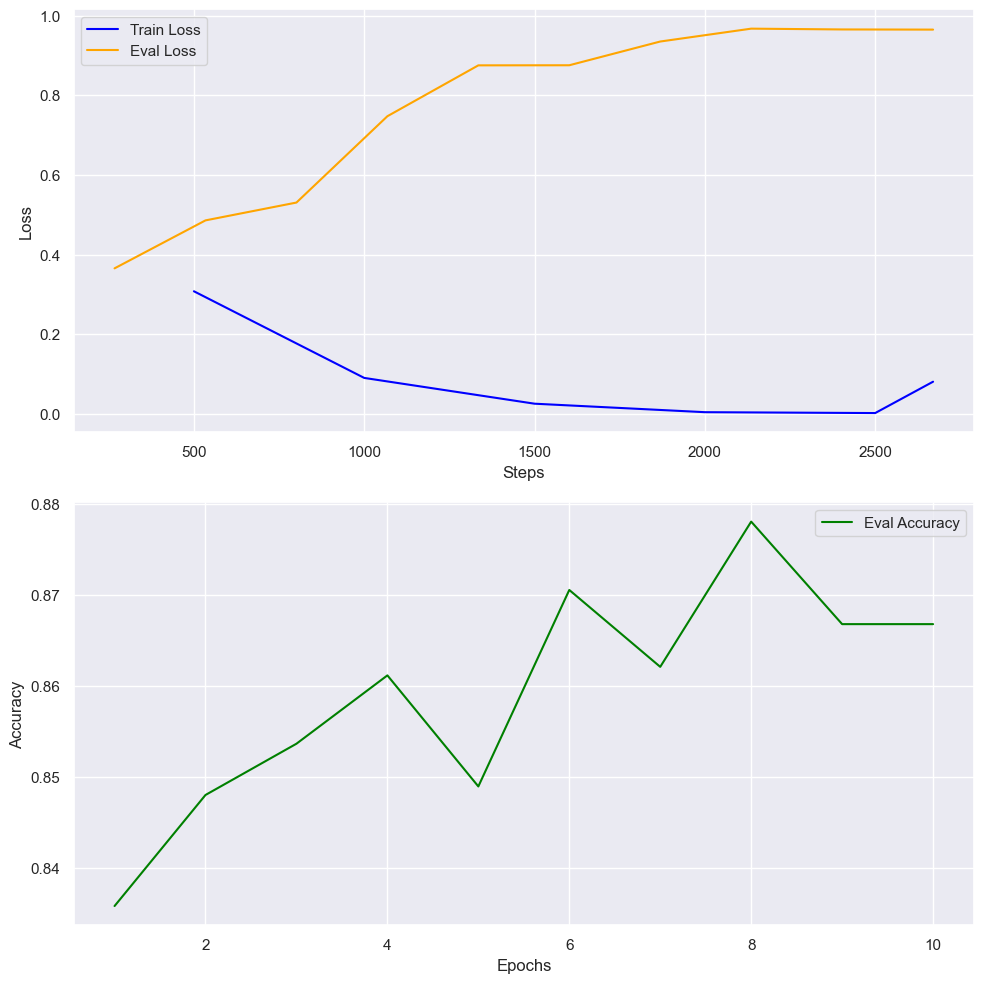

In [10]:
Bert_eval_steps, Bert_eval_epochs, Bert_train_steps, Bert_eval_loss, Bert_train_loss, Bert_eval_acc = get_metrics(Bert_base_train_metrics)
plot_metrics(Bert_eval_steps, Bert_eval_epochs, Bert_train_steps, Bert_eval_loss, Bert_train_loss, Bert_eval_acc)

По графикам видно, что на валидационной части выборки лосс растёт, что может сигнализировать о том, что при дальнейшем обучении может начаться переобучение. Однако на 10 эпохах с lr = ~E-5 , судя по accuracy, переобучения не наблюдается. В конце проверим на тесте

Теперь переходим к [Mixup](https://arxiv.org/abs/1710.09412) аугментации. В [статье](https://arxiv.org/abs/1905.08941) описывается смешивание как предложений так и эмбеддингов. Основная идея "смешать" эмбеддинги разных классов для аугментации данных, что позволяет разнообразить выборку. 

In [11]:
Bert_mixup = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
Bert_mixup.to(device)
print(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


In [12]:
from transformers import Trainer
import torch
import torch.nn.functional as F

# создаём кастомный класс тренера для применения mixup.
class MixupTrainer(Trainer):
    def __init__(self, *args, alpha=1.0, beta=1.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha # наши основные гиперпараметры которыми мы влияем на распределние
        # при помощи них мы можем регулировать вероятность соотношения классов
        self.beta = beta

    def compute_loss(self, model, inputs, return_outputs=False):
        input_ids = inputs.get("input_ids") 
        labels = inputs.get("labels")        
        attention_mask = inputs.get("attention_mask")

        if self.alpha > 0 and self.beta:  # при alpha/beta < 0 бета распределение не существует
            # Mixup
            lam = np.random.beta(self.alpha, self.beta)  # то самое соотношение классов
            batch_size = input_ids.size(0)
            index = torch.randperm(batch_size).to(input_ids.device) # перемещиваем индексы батча
            labels_a, labels_b = labels, labels[index]

            # получаем эмбеддинги
            embeddings = model.bert.embeddings(input_ids)
            embeddings_b = model.bert.embeddings(input_ids[index])

            # общий вид mixed = lam * a + (1 - lam) * b
            mixed_embeddings = lam * embeddings + (1 - lam) * embeddings_b
            mixed_attention_mask = attention_mask  # attention_mask не меняем

            # обновляем inputs 
            mixed_inputs = {
                "inputs_embeds": mixed_embeddings,
                "attention_mask": mixed_attention_mask,
                "labels": labels
            }
            # forward
            outputs = model(**mixed_inputs)
            logits = outputs.get("logits")
            # loss для Mixup
            loss = lam * F.cross_entropy(logits, labels_a) + (1 - lam) * F.cross_entropy(logits, labels_b)
        else: # если распределения не сущ-ет, то просто тюнем модель
            outputs = model(**inputs)
            logits = outputs("logits")
            loss = F.cross_entropy()(logits, labels)

        return (loss, outputs) if return_outputs else loss

Параметры распределения у нас по дефолту стоят равные единице. Это равновероятное соотвношенние классов
![](https://sun9-79.userapi.com/impg/YncqjsdzpdNMRkaZ8PNU_Kla4t5Qz47Xw6Ep0A/jv0vIDVBTaQ.jpg?size=1115x223&quality=96&sign=4a7884f2b4e35bcfcf36df230e8c3645&type=album)

Так как у нас не самый удачный датасет для экспериментов на аугментацию, то больше смысла имеет брать alpha = beta = 2, при которых перемешивание в равных частях более вероятно (этим мы займёмся дальше)

![](https://sun9-11.userapi.com/impg/Gq_2HFSXURkiemsKnVzfDmmUo_jOLofsT5WBPA/0gkU_1gp7mI.jpg?size=1161x250&quality=96&sign=3f769a5b8eec88f9b909565bc54e38f2&type=album)

In [13]:
Bert_mixup_trainer = MixupTrainer(
    model=Bert_mixup,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    alpha=1.0,
    beta=1.0
)

# Обучение модели
training_args.output_dir = './model_mixup'
Bert_mixup_train_metrics, Bert_mixup_eval_metrics = [], []
Bert_mixup_trainer.add_callback(SaveMetricsCallback(Bert_mixup_train_metrics, Bert_mixup_eval_metrics))
Bert_mixup_trainer.train()
torch.cuda.empty_cache()

  0%|          | 0/2670 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.45350489020347595, 'eval_accuracy': 0.801125703564728, 'eval_f1': 0.8203389830508474, 'eval_precision': 0.7480680061823802, 'eval_recall': 0.9080675422138836, 'eval_runtime': 10.2432, 'eval_samples_per_second': 104.069, 'eval_steps_per_second': 3.319, 'epoch': 1.0}
{'loss': 0.5702, 'grad_norm': 4.409434795379639, 'learning_rate': 6.50187265917603e-05, 'epoch': 1.87}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.40681758522987366, 'eval_accuracy': 0.8217636022514071, 'eval_f1': 0.8234200743494423, 'eval_precision': 0.8158379373848987, 'eval_recall': 0.8311444652908068, 'eval_runtime': 9.7523, 'eval_samples_per_second': 109.308, 'eval_steps_per_second': 3.486, 'epoch': 2.0}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.38459211587905884, 'eval_accuracy': 0.8377110694183865, 'eval_f1': 0.8322017458777886, 'eval_precision': 0.8614457831325302, 'eval_recall': 0.8048780487804879, 'eval_runtime': 10.3485, 'eval_samples_per_second': 103.01, 'eval_steps_per_second': 3.285, 'epoch': 3.0}
{'loss': 0.4656, 'grad_norm': 9.334749221801758, 'learning_rate': 5.00374531835206e-05, 'epoch': 3.75}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.4013538062572479, 'eval_accuracy': 0.8414634146341463, 'eval_f1': 0.842497670083877, 'eval_precision': 0.837037037037037, 'eval_recall': 0.8480300187617261, 'eval_runtime': 10.1658, 'eval_samples_per_second': 104.862, 'eval_steps_per_second': 3.345, 'epoch': 4.0}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.40275707840919495, 'eval_accuracy': 0.8236397748592871, 'eval_f1': 0.8315412186379928, 'eval_precision': 0.7958833619210978, 'eval_recall': 0.8705440900562852, 'eval_runtime': 9.8753, 'eval_samples_per_second': 107.946, 'eval_steps_per_second': 3.443, 'epoch': 5.0}
{'loss': 0.4145, 'grad_norm': 2.768683433532715, 'learning_rate': 3.50561797752809e-05, 'epoch': 5.62}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.39426878094673157, 'eval_accuracy': 0.8395872420262664, 'eval_f1': 0.8418131359851989, 'eval_precision': 0.8302919708029197, 'eval_recall': 0.8536585365853658, 'eval_runtime': 9.8893, 'eval_samples_per_second': 107.793, 'eval_steps_per_second': 3.438, 'epoch': 6.0}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.4348258972167969, 'eval_accuracy': 0.8198874296435272, 'eval_f1': 0.815028901734104, 'eval_precision': 0.8376237623762376, 'eval_recall': 0.7936210131332082, 'eval_runtime': 9.7156, 'eval_samples_per_second': 109.72, 'eval_steps_per_second': 3.5, 'epoch': 7.0}
{'loss': 0.3884, 'grad_norm': 7.770265102386475, 'learning_rate': 2.0074906367041202e-05, 'epoch': 7.49}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.39825576543807983, 'eval_accuracy': 0.8367729831144465, 'eval_f1': 0.8342857142857142, 'eval_precision': 0.8471953578336557, 'eval_recall': 0.8217636022514071, 'eval_runtime': 10.1816, 'eval_samples_per_second': 104.698, 'eval_steps_per_second': 3.339, 'epoch': 8.0}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.4351074695587158, 'eval_accuracy': 0.8367729831144465, 'eval_f1': 0.8370786516853933, 'eval_precision': 0.8355140186915888, 'eval_recall': 0.8386491557223265, 'eval_runtime': 10.2318, 'eval_samples_per_second': 104.185, 'eval_steps_per_second': 3.323, 'epoch': 9.0}
{'loss': 0.3674, 'grad_norm': 5.966331958770752, 'learning_rate': 5.093632958801499e-06, 'epoch': 9.36}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.3761807382106781, 'eval_accuracy': 0.873358348968105, 'eval_f1': 0.8730009407337724, 'eval_precision': 0.8754716981132076, 'eval_recall': 0.8705440900562852, 'eval_runtime': 10.2021, 'eval_samples_per_second': 104.488, 'eval_steps_per_second': 3.333, 'epoch': 10.0}
{'train_runtime': 2628.1406, 'train_samples_per_second': 32.456, 'train_steps_per_second': 1.016, 'train_loss': 0.43630917581279627, 'epoch': 10.0}


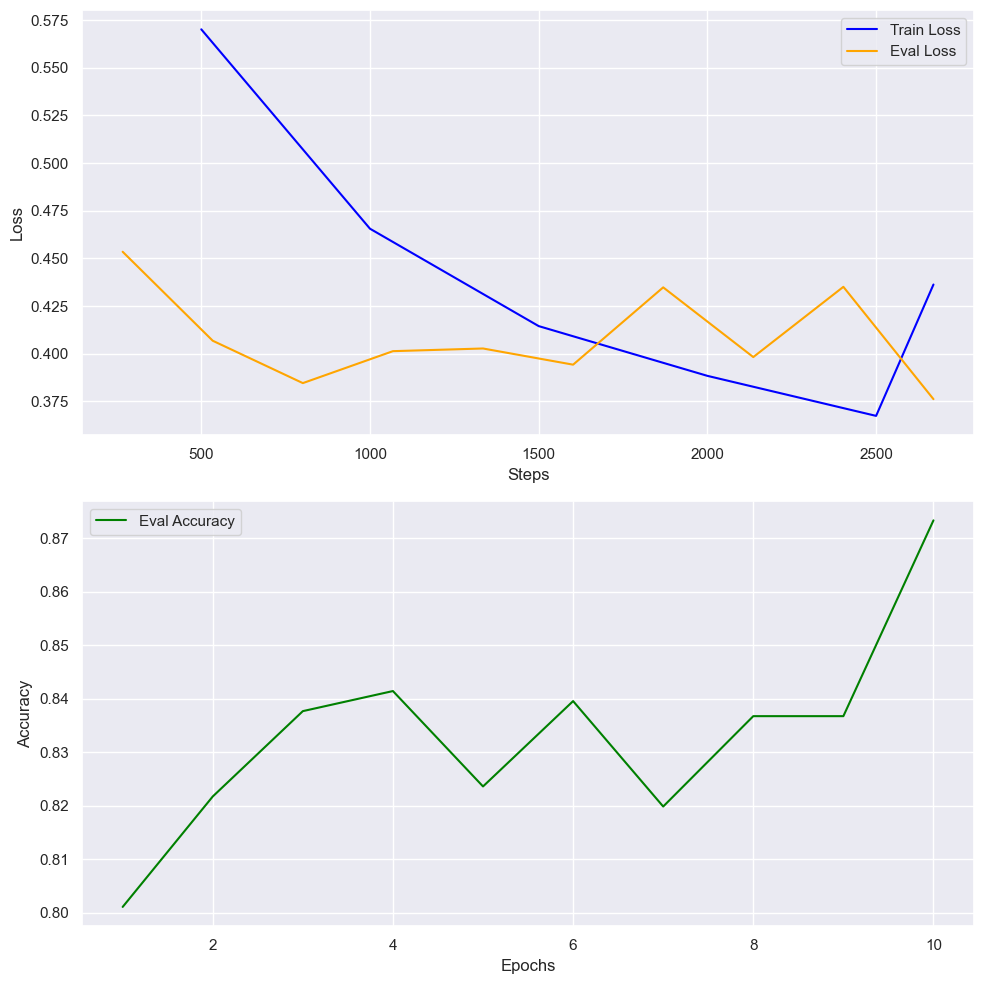

In [14]:
Bert_mixup_eval_steps, Bert_mixup_eval_epochs, Bert_mixup_train_steps,Bert_mixup_eval_loss, Bert_mixup_train_loss, Bert_mixup_eval_acc = get_metrics(Bert_mixup_train_metrics)
plot_metrics(Bert_mixup_eval_steps, Bert_mixup_eval_epochs, Bert_mixup_train_steps, Bert_mixup_eval_loss, Bert_mixup_train_loss, Bert_mixup_eval_acc)

На графиках для mixup видно, что на валидационной части выборки лосс теперь не растёт, что может говориить, о том что вероятность дальнейшего переобучения ниже. Полученная аккураси на последней эпохе чуть лучше чем без mixup, но максимальная чуть ниже

Попробуем увеличить параметры alpha и beta до 2.

In [15]:
Bert_mixup_2 = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
Bert_mixup_2.to(device)

Bert_mixup_trainer_2 = MixupTrainer(
    model=Bert_mixup,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    alpha=2.0,
    beta=2.0
)

# Обучение модели
training_args.output_dir = 'model_mixup_2'
Bert_mixup_2_train_metrics, Bert_mixup_2_eval_metrics = [], []
Bert_mixup_trainer_2.add_callback(SaveMetricsCallback(Bert_mixup_2_train_metrics, Bert_mixup_2_eval_metrics))
Bert_mixup_trainer_2.train()
torch.cuda.empty_cache()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/2670 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.4242849349975586, 'eval_accuracy': 0.8180112570356473, 'eval_f1': 0.8330464716006885, 'eval_precision': 0.7694753577106518, 'eval_recall': 0.9080675422138836, 'eval_runtime': 10.4258, 'eval_samples_per_second': 102.246, 'eval_steps_per_second': 3.261, 'epoch': 1.0}
{'loss': 0.4454, 'grad_norm': 13.412076950073242, 'learning_rate': 6.50187265917603e-05, 'epoch': 1.87}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.3896787166595459, 'eval_accuracy': 0.849906191369606, 'eval_f1': 0.8532110091743118, 'eval_precision': 0.8348294434470377, 'eval_recall': 0.8724202626641651, 'eval_runtime': 10.1583, 'eval_samples_per_second': 104.939, 'eval_steps_per_second': 3.347, 'epoch': 2.0}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.41116079688072205, 'eval_accuracy': 0.8348968105065666, 'eval_f1': 0.8297872340425532, 'eval_precision': 0.8562874251497006, 'eval_recall': 0.8048780487804879, 'eval_runtime': 10.1799, 'eval_samples_per_second': 104.716, 'eval_steps_per_second': 3.34, 'epoch': 3.0}
{'loss': 0.4357, 'grad_norm': 3.199270009994507, 'learning_rate': 5.00374531835206e-05, 'epoch': 3.75}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.4004462659358978, 'eval_accuracy': 0.8395872420262664, 'eval_f1': 0.8403361344537814, 'eval_precision': 0.8364312267657993, 'eval_recall': 0.8442776735459663, 'eval_runtime': 10.1703, 'eval_samples_per_second': 104.815, 'eval_steps_per_second': 3.343, 'epoch': 4.0}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.4214015603065491, 'eval_accuracy': 0.8208255159474672, 'eval_f1': 0.8147429679922406, 'eval_precision': 0.8433734939759037, 'eval_recall': 0.7879924953095685, 'eval_runtime': 10.3448, 'eval_samples_per_second': 103.047, 'eval_steps_per_second': 3.287, 'epoch': 5.0}
{'loss': 0.3995, 'grad_norm': 4.853351593017578, 'learning_rate': 3.50561797752809e-05, 'epoch': 5.62}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.3809437155723572, 'eval_accuracy': 0.8461538461538461, 'eval_f1': 0.8404669260700389, 'eval_precision': 0.8727272727272727, 'eval_recall': 0.8105065666041276, 'eval_runtime': 9.8443, 'eval_samples_per_second': 108.286, 'eval_steps_per_second': 3.454, 'epoch': 6.0}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.3664996027946472, 'eval_accuracy': 0.8555347091932458, 'eval_f1': 0.8549905838041432, 'eval_precision': 0.8582230623818525, 'eval_recall': 0.851782363977486, 'eval_runtime': 9.6962, 'eval_samples_per_second': 109.94, 'eval_steps_per_second': 3.507, 'epoch': 7.0}
{'loss': 0.3934, 'grad_norm': 1.9576829671859741, 'learning_rate': 2.0074906367041202e-05, 'epoch': 7.49}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.3797055780887604, 'eval_accuracy': 0.8414634146341463, 'eval_f1': 0.8448117539026629, 'eval_precision': 0.8273381294964028, 'eval_recall': 0.8630393996247655, 'eval_runtime': 9.696, 'eval_samples_per_second': 109.943, 'eval_steps_per_second': 3.507, 'epoch': 8.0}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.4226229786872864, 'eval_accuracy': 0.8348968105065666, 'eval_f1': 0.8417266187050358, 'eval_precision': 0.8082901554404145, 'eval_recall': 0.8780487804878049, 'eval_runtime': 9.6569, 'eval_samples_per_second': 110.387, 'eval_steps_per_second': 3.521, 'epoch': 9.0}
{'loss': 0.3877, 'grad_norm': 3.447489023208618, 'learning_rate': 5.093632958801499e-06, 'epoch': 9.36}


  0%|          | 0/34 [00:00<?, ?it/s]

{'eval_loss': 0.38141751289367676, 'eval_accuracy': 0.8592870544090057, 'eval_f1': 0.8592870544090057, 'eval_precision': 0.8592870544090057, 'eval_recall': 0.8592870544090057, 'eval_runtime': 9.8579, 'eval_samples_per_second': 108.137, 'eval_steps_per_second': 3.449, 'epoch': 10.0}
{'train_runtime': 2599.6901, 'train_samples_per_second': 32.812, 'train_steps_per_second': 1.027, 'train_loss': 0.41033814390946866, 'epoch': 10.0}


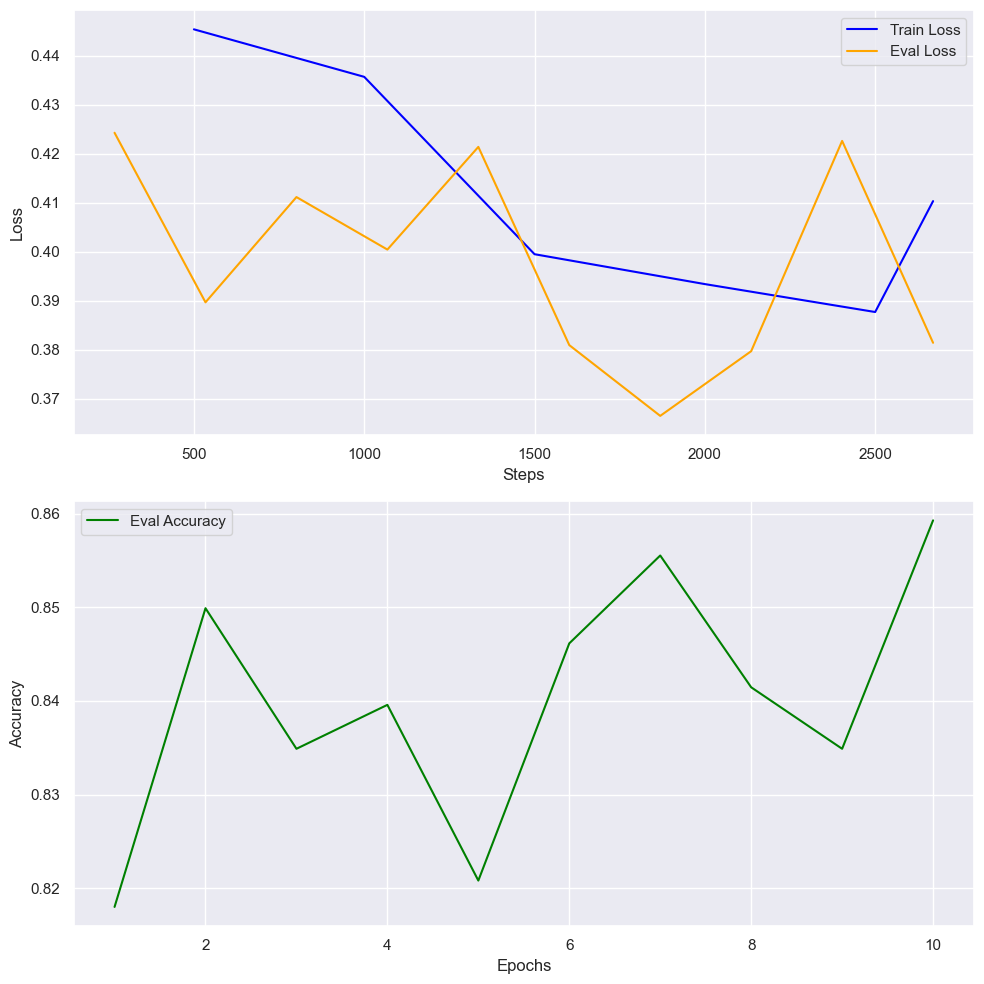

In [16]:
Bert_mixup_2_eval_steps, Bert_mixup_2_eval_epochs, Bert_mixup_2_train_steps, Bert_mixup_2_eval_loss, Bert_2_mixup_train_loss, Bert_2_mixup_eval_acc = get_metrics(Bert_mixup_2_train_metrics)
plot_metrics(Bert_mixup_2_eval_steps, Bert_mixup_2_eval_epochs, Bert_mixup_2_train_steps, Bert_mixup_2_eval_loss, Bert_2_mixup_train_loss, Bert_2_mixup_eval_acc)

При увеличении alpha и beta до 2 лоссы выедут себя относительно похожим образом. Аккураси же снизилось. Скорее всего это вызвано тем, что у нас появилось больше "пограничных" случаев на которых надо дольше обучаться. Также для улучшения результата, верояно, следует применять интерполяцию для лейблов

In [19]:
eval_data = {
    'BERT base w/o augmentations': Bert_eval_acc,
    'mixup, alpha = beta = 1.0': Bert_mixup_eval_acc,
    'mixup, alpha = beta = 2.0': Bert_2_mixup_eval_acc
}
df = pd.DataFrame(eval_data)
summary_eval_data = pd.DataFrame({
    'Average': df.mean(),
    'Maximum': df.max()
}).T
summary_eval_data

,BERT base w/o augmentations,"mixup, alpha = beta = 1.0","mixup, alpha = beta = 2.0"
Average,0.859193,0.833208,0.840056
Maximum,0.878049,0.873358,0.859287


Лучший результат на имеющихся параметрах показал обычный подфайнтюненный BERT. Связано это с датасетом. Он сбалансирован и, в целом, не требует аугментации данных. mixup же в свою очередь должен быть хорош для ***few shot*** задач